In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
im = imread('../data/denoising/saturn.png')
noise1 = imread('../data/denoising/saturn-noisy.png')
error1 = ((im - noise1)**2).sum()
print ('Noisy image SE: {:.2f}'.format(error1))

Noisy image SE: 361.80


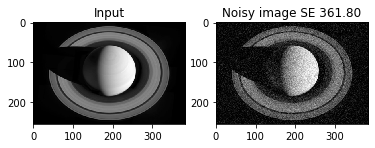

In [3]:
plt.figure(1)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Input')

plt.subplot(122)
plt.imshow(noise1, cmap='gray')
plt.title('Noisy image SE {:.2f}'.format(error1))

plt.show(block=False)

In [26]:
class EncDec1(nn.Module):

    def __init__(self):
        super(EncDec1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3
        self.bn3 = nn.BatchNorm2d(64)
        
        self.conv31 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 3
        self.bn31 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(.25)
        
        self.conv32 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 3
        self.bn32 = nn.BatchNorm2d(256)
        #self.dropout32 = nn.Dropout(.25)
        
        self.upsample01 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv01 = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 1
        self.bn01 = nn.BatchNorm2d(256)
        
        self.upsample02 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv02 = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 1
        self.bn02 = nn.BatchNorm2d(128)
        
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv4 = nn.Conv2d(128, 64, 3, 1, 1) # Decoder - 1
        self.bn4 = nn.BatchNorm2d(64)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv5 = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2 
        self.bn5 = nn.BatchNorm2d(32)
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv6 = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 3
        self.bn6 = nn.BatchNorm2d(16)
        
        self.conv7 = nn.Conv2d(16, 1, 3, 1, 1) # Channe-1
        
    def forward(self, x):
        out = self.bn1(F.relu(self.conv1(x)))
        #print (out.shape)
        out = self.bn2(F.relu(self.conv2(out)))
        #print (out.shape)
        out = self.bn3(self.dropout3(F.relu(self.conv3(out))))
        #print (out.shape)
        out = self.bn31(self.dropout3(F.relu(self.conv31(out))))
        #print (out.shape)
        out = self.bn32(self.dropout3(F.relu(self.conv32(out))))
        #print (out.shape)
        out = self.upsample01(self.bn01(self.dropout3(F.relu(self.conv01(out)))))
        #print (out.shape)
        out = self.upsample02(self.bn02(self.dropout3(F.relu(self.conv02(out)))))
        #print (out.shape)
        out = self.upsample1(self.bn4(self.dropout3(F.relu(self.conv4(out)))))
        #print (out.shape)
        out = self.upsample2(self.bn5(F.relu(self.conv5(out))))
        #print (out.shape)
        out = self.upsample3(self.bn6(F.relu(self.conv6(out))))
        #print (out.shape)
        out = F.relu(self.conv7(out))
        #print (out.shape)
        return out

In [ ]:
MAX_EPOCHS = 5000

net = EncDec1()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS):
    out = net(eta)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward + Backward + Optimize 
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        curr_error = ((im - out_img)**2).sum()
        print ("Loss = {}, Error = {}".format(loss.detach().numpy().reshape(-1)[0], curr_error))

Loss = 0.1435168981552124, Error = 14108.285690105353
Loss = 0.0049870191141963005, Error = 490.24392942336976
Loss = 0.003727714531123638, Error = 366.4492499089619
Loss = 0.003004956291988492, Error = 295.3992166384833
Loss = 0.0024184694048017263, Error = 237.74522315605236
Loss = 0.0024519984144717455, Error = 241.0412590204861
Loss = 0.002223062561824918, Error = 218.53593401861608
Loss = 0.002051778370514512, Error = 201.69802056164872
Loss = 0.002020763698965311, Error = 198.64915893790075
Loss = 0.001781263155862689, Error = 175.10529179433948
Loss = 0.0018677435582503676, Error = 183.6066663380492
Loss = 0.0014838296920061111, Error = 145.86639793568366
Loss = 0.0015247160336002707, Error = 149.88568295599575
Loss = 0.001483671716414392, Error = 145.85086506150108
Loss = 0.0013964931713417172, Error = 137.2808677278069
Loss = 0.001409413991495967, Error = 138.55103577177516
Loss = 0.0013078548945486546, Error = 128.56736211569321
Loss = 0.0013440863694995642, Error = 132.12906